In [39]:
import cv2
import math
import random
import numpy as np
from matplotlib import pyplot as plt

In [40]:
def pad_frames(frames, limit, jpegs=False):
        last_frame = frames[-1]
        if jpegs:
            frames_padded = frames + [last_frame]*(limit-len(frames))
        else:
            padding = np.asarray([last_frame * 1.]*(limit-len(frames)))
            frames_padded = np.concatenate([frames, padding], axis=0)
        return frames_padded

def resize_frames(frames):
  new_frames = []
  for frame in frames:
    new_frame = cv2.resize(frame,(224,224))
    new_frames.append(new_frame)
  
  return new_frames

def extract_frames_sampled(frames, K):
        n_frames = len(frames)
        splits = [i  for i in range(0,n_frames,14)]
#         print(splits)
        sub_frames = []

        for idx in splits:
          sub_frames.append(frames[idx])
        return sub_frames


In [41]:
K = 28
cap = cv2.VideoCapture('/kaggle/input/msvd-clips/YouTubeClips/-_hbPLsZvvo_288_305.avi')
frames = []
while  cap.isOpened():
    ret, frame = cap.read()
    if not ret: break # break if no next frame
    frames.append(frame)
    
if len(frames) < K:
        frames = pad_frames(frames,K,True)

frames = resize_frames(frames)
frames = extract_frames_sampled(frames,14)
print(len(frames))
   
        

73


In [42]:
metric_values = []
for i in range(1,len(frames)):
#         hist_img1 = cv2.calcHist(frames[i], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
        hist_img1 = cv2.calcHist([frames[i]], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
        cv2.normalize(hist_img1, hist_img1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
#         hist_img2 = cv2.calcHist(frames[i-1], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
        hist_img2 = cv2.calcHist([frames[i-1]], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
        cv2.normalize(hist_img2, hist_img2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        metric_val1 = cv2.compareHist(hist_img1, hist_img2, cv2.HISTCMP_CHISQR)
        metric_values.append(metric_val1)

In [43]:
# print(metric_values)
delta = []
mean = np.mean(metric_values)
print('Mean =' + str(mean))
processed_frames = []
for i in range(0,len(metric_values)):
    if metric_values[i] >= mean : 
        processed_frames.append(frames[i])
        delta.append(i+1)
print(len(processed_frames))

Mean =493.65002383050603
31


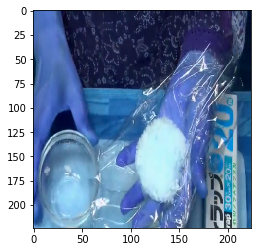

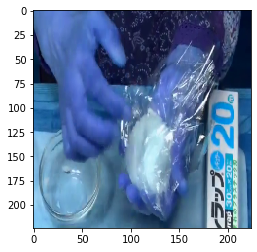

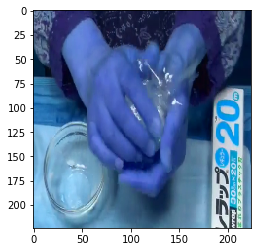

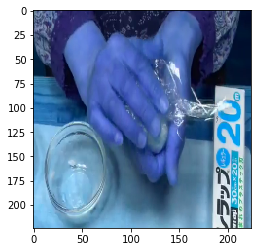

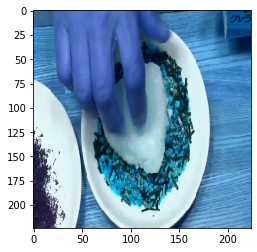

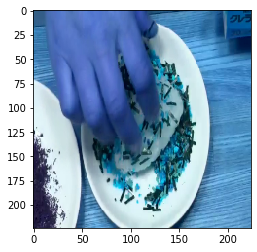

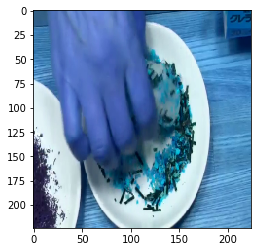

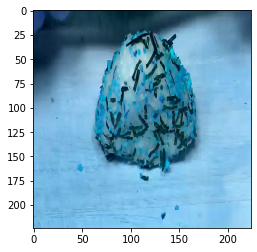

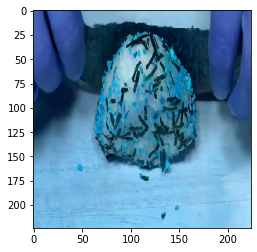

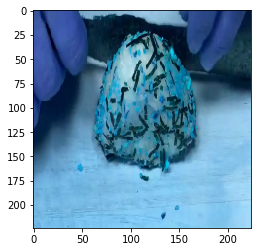

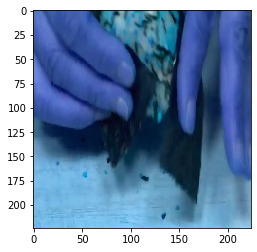

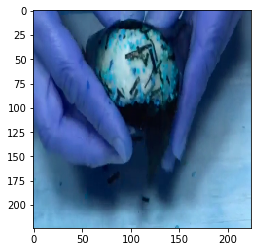

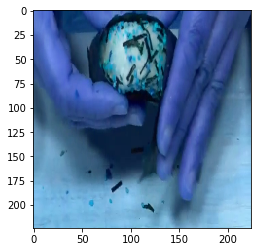

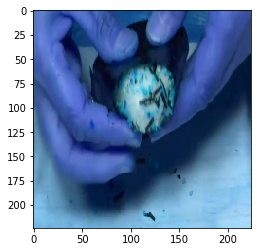

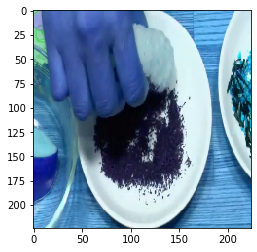

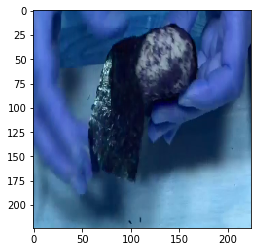

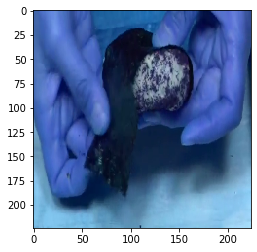

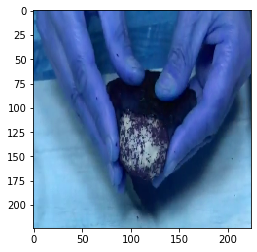

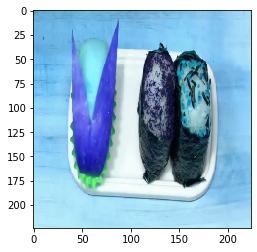

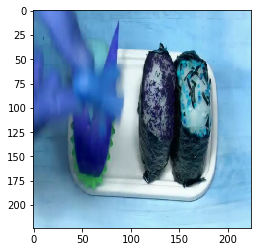

In [44]:
for i in range (len(processed_frames)):
    plt.imshow(processed_frames[i], interpolation='nearest')
    plt.show()

# **Genetic Algorithm**

### **Fitness Function**

In [45]:
hist_score = dict()

def calc_histscore(frames):
    for i in range(0,len(frames)):
        for j in range (i+1,len(frames)):
            hist_img1 = cv2.calcHist([frames[i]], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
            cv2.normalize(hist_img1, hist_img1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
            hist_img2 = cv2.calcHist([frames[j]], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
            cv2.normalize(hist_img2, hist_img2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
            metric_val = cv2.compareHist(hist_img1, hist_img2, cv2.HISTCMP_CHISQR)
            hist_score[(i,j)] = metric_val
    



def fitness_func(frames,delta,fit_idx):
#     print('MEAN STD',mean+std)
    
    hist_data = []
    score1 = 0
    score2 = []  #importance score
    final_score = 0
#     print('LEN = ',len(frames))

    for i in range(0,len(frames)):
        for j in range (i+1,len(frames)):
            metric_val = hist_score[(fit_idx[i],fit_idx[j])]
            hist_data.append(metric_val)
    mean = np.mean(hist_data)
    std = np.std(hist_data)
            
    for i in range(0,len(frames)):
        net_mean = 0
        c = 0
        for j in range (i+1,len(frames)):
            metric_val = hist_score[(fit_idx[i],fit_idx[j])]
#             print('Metric',metric_val)
            if metric_val < (mean+std):
                net_mean +=metric_val
                c+=1
        if c>0:
           net_mean = net_mean/(c)
        net_mean/=mean
        score2.append(math.log(delta[i])*(math.log(1/(net_mean+1))))
    
#     print('NET_MEAN : ',net_mean)
    
    for i in range(0,len(frames)):
        net_mean = 0
        c = 0
        for j in range (i+1,len(frames)):
            metric_val  = hist_score[(i,j)]
            final_score += (metric_val*score2[i]*score2[j])/((i-j)*(i-j))
    return final_score

In [46]:
print(len(processed_frames))

31


In [47]:
# if len(processed_frames) <28:
#     processed_frames = pad_frames(processed_frames,28)

In [48]:
calc_histscore(processed_frames)

In [ ]:
# print(hist_score)

In [50]:
print(delta)

[2, 3, 4, 5, 6, 7, 8, 12, 13, 14, 19, 25, 28, 30, 36, 37, 38, 39, 41, 42, 43, 44, 45, 53, 58, 59, 61, 62, 63, 71, 72]


In [51]:
# print(processed_frames)

### **Crossover and Mutation**

**Initialisizing population**

In [79]:
txt = ""
chromosome = txt.zfill(len(processed_frames))
# print(len(chromosome))
# print(chromosome)

p1 = list(chromosome)
p2 = list(chromosome)
p3 = list(chromosome)
p4 = list(chromosome)

c1 = min(28,len(processed_frames))

for i in range(c1):
    p1[i]='1'
    p2[i]='1'
    p3[i]='1'
    p4[i]='1'
    
#generating random population
random.shuffle(p1)
random.shuffle(p2)
random.shuffle(p3)
random.shuffle(p4)

print(p1)
print(p2)
print(p3)
print(p4)

['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '0', '1', '1', '1']
['1', '1', '1', '1', '1', '1', '1', '0', '1', '0', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1']
['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '0', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1']
['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '0', '1', '1', '1']


 **CrossOver**

In [53]:
def crossover(l, q):
#     print(len(l),len(q))
# generating the random number to perform crossover
    k = random.randint(0, len(l))
    print("Crossover point :", k)
# interchanging the genes
    for i in range(k, len(q)):
        l[i], q[i] = q[i], l[i]
    return l, q

**Mutation**

In [54]:
def mutation(l):
    count0 = []
    count1 = []
    for i in range(len(l)):
        if(l[i]=='0'):
            count0.append(i)
        else:
            count1.append(i)
            
    mutation_points = []
    change = ''
    req = min(len(l),28)
    
    if len(count1) <req:
        mutation_points = random.sample(count0,req-len(count1))
        change = '1'
    elif len(count1) >req:
        mutation_points = random.sample(count1,len(count1)-req)
        change = '0'
        
    for i in mutation_points:
        l[i] = change
    
    return l
#     print(mutation_points)
        
          

In [55]:
# p1,p2 = crossover(p1,p2)
# mutation(p1)

**Select Parents**

In [56]:
def select_parents(population,fitness_values):
  parents = []
  total = sum(fitness_values)
  norm_fitness_values = [x/total for x in fitness_values]

  #find cumulative fitness values for roulette wheel selection
  cumulative_fitness = []
  start = 0
  for norm_value in norm_fitness_values:
    start+=norm_value
    cumulative_fitness.append(start)

  population_size = len(population)
  for count in range(population_size):
    random_number = random.uniform(0, 1)
    individual_number = 0
    for score in cumulative_fitness:
      if(random_number<=score):
        parents.append(population[individual_number])
        break
      individual_number+=1
      
  return parents

**Performing GA**

In [80]:
iteration = 10
threshold = 300
solution = []

prev_generation = [p1,p2,p3,p4]
curr_generation = []
max_fitness_idx = 0

for i in range(iteration):
        print('ITERATION : ',i)
        print(prev_generation[0])
        print('---------------------------------------------------')
        p1,p2,p3,p4 = prev_generation[0],prev_generation[1],prev_generation[2],prev_generation[3]
        fitness1 = [processed_frames[j] for j in range(len(p1)) if p1[j] == '1']
        fitness2 = [processed_frames[j] for j in range(len(p2)) if p2[j] == '1']
        fitness3 = [processed_frames[j] for j in range(len(p3)) if p3[j] == '1']
        fitness4 = [processed_frames[j] for j in range(len(p4)) if p4[j] == '1']


        fit1_idx = [j for j in range(len(p1)) if p1[j] == '1']
        fit2_idx = [j for j in range(len(p2)) if p2[j] == '1']
        fit3_idx = [j for j in range(len(p3)) if p3[j] == '1']
        fit4_idx = [j for j in range(len(p4)) if p4[j] == '1']

    #     print(fit1_idx)
    #     print(fit2_idx)

        fit1_score = fitness_func(fitness1,delta,fit1_idx)
        fit2_score = fitness_func(fitness2,delta,fit2_idx)
        fit3_score = fitness_func(fitness3,delta,fit3_idx)
        fit4_score = fitness_func(fitness4,delta,fit4_idx)
        
        print('NetFitnessScore : ',sum([fit1_score,fit2_score,fit3_score,fit4_score]))
        while len(curr_generation)<4:
            parent1,parent2,parent3,parent4 = select_parents(prev_generation,[fit1_score,fit2_score,fit3_score,fit4_score])

    #     print(fit1_score)
            parent1,parent2 = crossover(parent1,parent2)
            parent1 = mutation(parent1)
            parent2 = mutation(parent2)

            curr_generation.append(parent1)
            curr_generation.append(parent2)

        prev_generation = curr_generation
        curr_generation = []
        print('---------------------------------------------------')
    
#     print('NET SCORE : ',abs(fit1_score-fit2_score))
    
# if(abs(fit1_score-fit2_score)<threshold or i+1 == iteration):
solution = prev_generation[0]
#         break
    

ITERATION :  0
['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '0', '1', '1', '1']
---------------------------------------------------
NetFitnessScore :  343658.27643548127
Crossover point : 21
Crossover point : 28
---------------------------------------------------
ITERATION :  1
['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '0', '1', '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1']
---------------------------------------------------
NetFitnessScore :  345798.63939698035
Crossover point : 28
Crossover point : 2
---------------------------------------------------
ITERATION :  2
['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '0', '1', '1', '1', '1', '1', '0', '1', '1', '1']
---------------------------------------------------
NetFitnessScore :  345798.63939698035
Crossover point : 19
Crossover

In [84]:
solution = fitness1 = [processed_frames[j] for j in range(len(prev_generation[0])) if prev_generation[0][j] == '1'] 

In [85]:
print(len(solution))

28


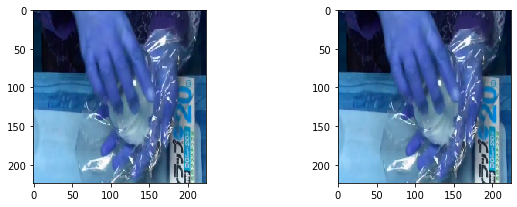

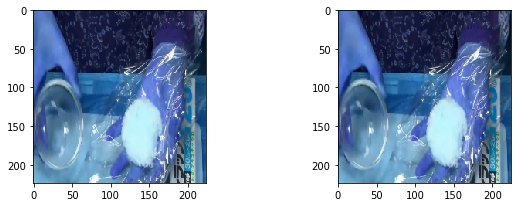

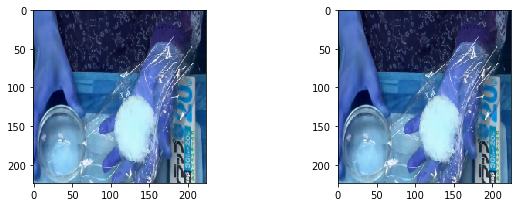

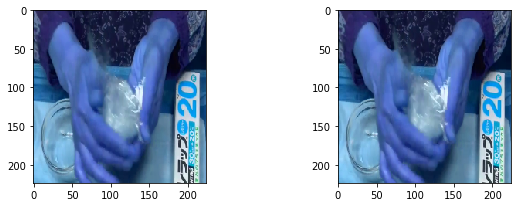

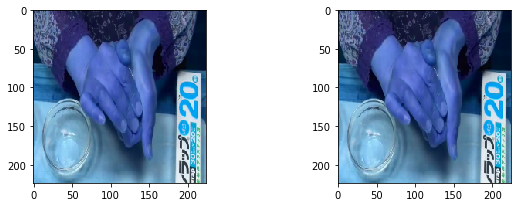

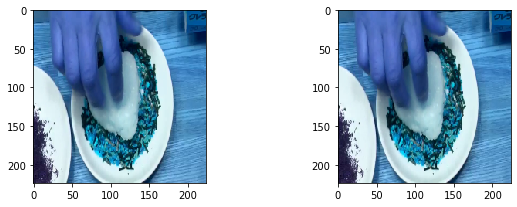

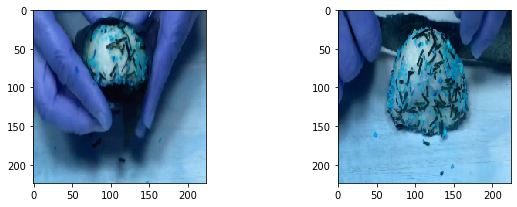

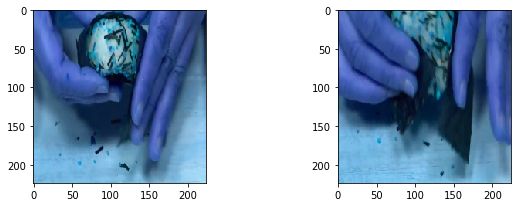

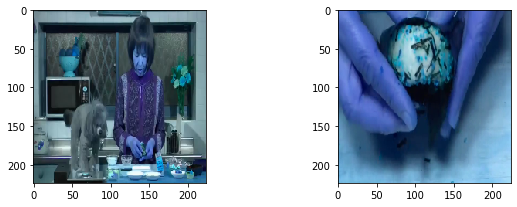

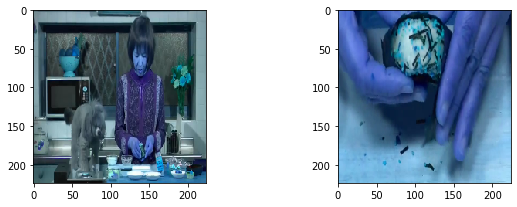

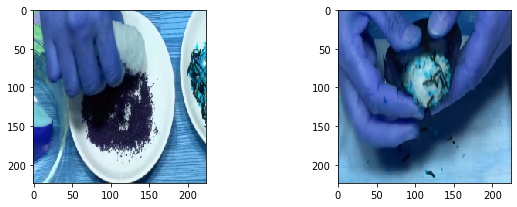

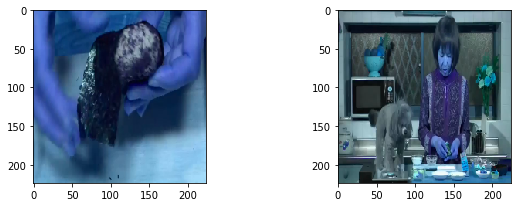

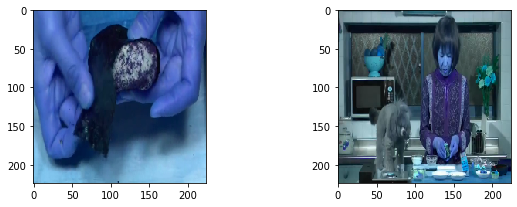

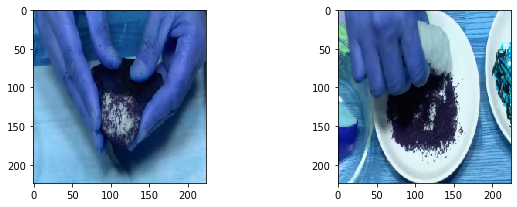

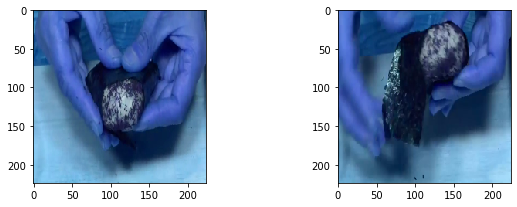

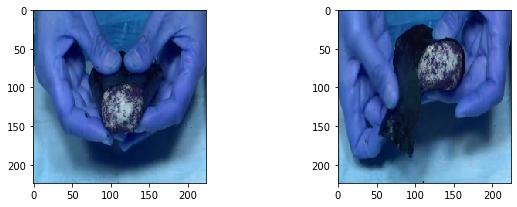

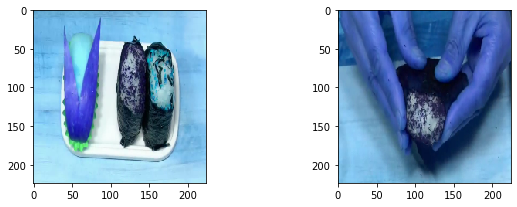

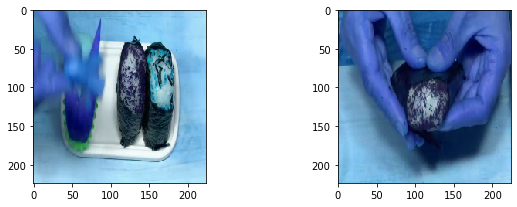

In [86]:

for i in range (len(solution)):
    fig = plt.figure(figsize=(10, 7))
    fig.add_subplot(2, 2, 1)
    plt.imshow(solution[i], interpolation='nearest')
    fig.add_subplot(2, 2, 2)
    plt.imshow(processed_frames[i], interpolation='nearest')
    plt.show()

In [ ]:
if len(solution) <28:
    processed_frames = pad_frames(solution,28)

In [ ]:
file = '-7KMZQEsJW4_205_2081.avi'
np.save(file[:-4],solution)